# 用于识别不定长数字串

# 实现工具：
* tensorflow 1.9.0 
* CUDA 9.0

# 网络结构
* CNN + LSTM + CTC

In [1]:
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from PIL import Image
import math
import timeit

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

test_mode = False

/home/luo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 载入CVL数据集

In [2]:
def loda_cvl_string(path):

    label = []
    begin = True
    for root, dirs, files in os.walk(path):
        for file in files: 
#             print("file: %s " % file) #当前路径下所有非目录子文件 
#             img = Image.open('/home/luo/文档/dataset/handwritting digital string/cvl-strings/train/' + file).resize((200,50), Image.ANTIALIAS)
            img = Image.open(path + file).resize((200,50), Image.ANTIALIAS)
            if begin:
                date_train = np.array(img)
                begin = False
            else:
                date_train = np.concatenate([date_train, img])
            string = []
            for s in file:
                if s == '-':
                    string = [int(i) for i in string]
                    label.append(string)
                    break
                string += s

    data_label = np.array(label)
    num = data_label.shape[0]

    date_train = date_train.reshape(num, 50, 200, 3)
    for i in range(num):
        data_label_temp = np.array(label[i])
        data_label[i] = data_label_temp

    num_training = 1088
    num_validation = 160
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = date_train[mask]
    y_val = data_label[mask]
    mask = range(num_training)
    X_train = date_train[mask]
    y_train = data_label[mask]

    print('Train data shape: ', X_train.shape)
    print('Train labels shape: ', y_train.shape)
    print('Validation data shape: ', X_val.shape)
    print('Validation labels shape: ', y_val.shape)
    
    return X_train, y_train, X_val, y_val

测试载入数据，若图与label不一致，则出错
* label:0 1 2 3 4 5 6 7 8 9

Train data shape:  (1088, 50, 200, 3)
Train labels shape:  (1088,)
Validation data shape:  (160, 50, 200, 3)
Validation labels shape:  (160,)


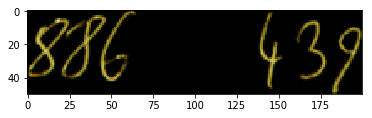

[8 8 6 4 3 9]


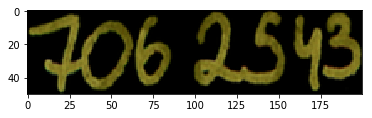

[7 0 6 2 5 4 3]


In [3]:
path = '/home/luo/文档/dataset/handwritting digital string/cvl-strings/train/'
X_train, y_train, X_val, y_val = loda_cvl_string(path)

# 输入数据前先对数据进行归一化、中心化
# X_train = X_train
# X_val = X_val 
# mean_image = np.mean(X_train, axis=0, dtype = np.uint8)
X_train = (255 - X_train) / 255
X_val = (255 - X_val) / 255
mean_image = np.mean(X_train, axis=0)#, dtype = np.uint8)

X_train -= mean_image
X_val -= mean_image

plt.imshow(X_train[0] + mean_image)
plt.show()
print(y_train[0])

plt.imshow(X_val[0] + mean_image)
plt.show()
print(y_val[0])

## 将dense转化为稀疏矩阵，用作CTC输入  
## feed sparse注意事项  

https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/sparse_placeholder

x = tf.sparse_placeholder(tf.float32)  
y = tf.sparse_reduce_sum(x)

with tf.Session() as sess:
  print(sess.run(y))  # ERROR: will fail because x was not fed.

  indices = np.array([[3, 2, 0], [4, 5, 1]], dtype=np.int64)  
  values = np.array([1.0, 2.0], dtype=np.float32)  
  shape = np.array([7, 9, 2], dtype=np.int64)  
  
  print(sess.run(y, feed_dict={  
    x: tf.SparseTensorValue(indices, values, shape)}))  # Will succeed.  
  print(sess.run(y, feed_dict={  
    x: (indices, values, shape)}))  # Will succeed.  
  
  sp = tf.SparseTensor(indices=indices, values=values, dense_shape=shape)  
  sp_value = sp.eval(session)  
  print(sess.run(y, feed_dict={x: sp_value}))  # Will succeed.  


In [4]:
def dense_to_sparse(dense,dtype=np.int32):
    '''
    把密集矩阵转换为稀疏矩阵
    
    args:
        dense：密集矩阵
        dtype：稀疏矩阵值得类型
    '''
    indices = []
    values = []
    
    #遍历每一行
    for n,seq in enumerate(dense):        
        #在已存在的列表中添加新的列表内容  添加密集矩阵每个索引位置
        indices.extend(zip([n]*len(seq),range(len(seq))))
        #添加密集矩阵每个元素的值
        values.extend(seq)
        
        
    indices = np.asarray(indices,dtype = np.int64)
    values = np.asarray(values,dtype = dtype)    
    shape = np.asarray([len(dense),indices.max(0)[1]+1],dtype = np.int64)            
    return tf.SparseTensor(indices = indices,values = values,dense_shape = shape) 

测试稀疏矩阵是否正确

In [5]:
if test_mode:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sparse_train = dense_to_sparse(y_train)
        s = sess.run(sparse_train)
        print(s.indices)
        print(s.values)
        print(s.dense_shape)
        sparse_val = dense_to_sparse(y_val)
        s = sess.run(sparse_val)
        print(s.indices)
        print(s.values)
        print(s.dense_shape)

## 定义CNN网络，提取特征
* image_batch->CNN->[batch_size,max_time_step,num_features]

In [6]:
BATCH_SIZE = 32
MAX_TIME_STEP = 32
FEATURES = 128

tf.reset_default_graph() # 清空之前的graph
X = tf.placeholder(tf.float32, [None, 50, 200, 3])
is_training = tf.placeholder(tf.bool)
def conv_layers(X,is_training):
    
    #first conv layer 50*200*3->44*194*32
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32]) # conv1层参数
    bconv1 = tf.get_variable("bconv1", shape=[32])
    out_conv_1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding="VALID") + bconv1 # conv1
    out_relu_1 = tf.nn.relu(out_conv_1) 
    batch_norm_1 = tf.layers.batch_normalization(out_relu_1, axis = 1, training = is_training)
    
    #first pool layer 44*194*32->22*96*32
    max_pool_1 = tf.nn.max_pool(batch_norm_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    #second conv layer 22*96*32->18*92*64
    Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 32, 64]) # conv1层参数
    bconv2 = tf.get_variable("bconv2", shape=[64])
    out_conv_2 = tf.nn.conv2d(max_pool_1, Wconv2, strides=[1,1,1,1], padding="VALID") + bconv2
    out_relu_2 = tf.nn.relu(out_conv_2)
    batch_norm_2 = tf.layers.batch_normalization(out_relu_2, axis = 1, training = is_training)
    
    #second pool layer 18*92*64->9*46*64
    max_pool_2 =tf.nn.max_pool(batch_norm_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    #third conv layer 9*46*64->7*44*128
    Wconv3 = tf.get_variable("Wconv3", shape=[3, 3, 64, 128]) # conv1层参数
    bconv3 = tf.get_variable("bconv3", shape=[128])
    out_conv_3 = tf.nn.conv2d(max_pool_2, Wconv3, strides=[1,1,1,1], padding="VALID") + bconv3
    out_relu_3 = tf.nn.relu(out_conv_3)
    batch_norm_3 = tf.layers.batch_normalization(out_relu_3, axis = 1, training = is_training)
    
    #second pool layer 7*44*128->3*22*128
    max_pool_3 =tf.nn.max_pool(batch_norm_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    #first fc layer
    W1 = tf.get_variable("W1", shape=[3*22*128, 32*128]) # fc-net1参数
    b1 = tf.get_variable("b1", shape=[32*128])
    out_pool_flat = tf.reshape(max_pool_3, [-1, 3*22*128])
    dropout_1 = tf.layers.dropout(out_pool_flat, rate = 0.5, training = is_training)
    out_fc_1 = tf.matmul(dropout_1, W1) + b1
    out_fc_relu_1 = tf.nn.relu(out_fc_1)    
    batch_norm_4 = tf.layers.batch_normalization(out_fc_relu_1, axis = -1, training = is_training)
   
    #second fc layer
    W2 = tf.get_variable("W2", shape=[32*128, 32*128]) # fc-net1参数
    b2 = tf.get_variable("b2", shape=[32*128])
    dropout_2 = tf.layers.dropout(batch_norm_4, rate = 0.5, training = is_training)
    out_fc_2 = tf.matmul(dropout_2, W2) + b2
    out_fc_relu_2 = tf.nn.relu(out_fc_2)    
    
    features = out_fc_relu_2
    shape = tf.shape(features)
    batch_features = tf.reshape(features, [shape[0], MAX_TIME_STEP, FEATURES])
    
    return batch_features

## 定义RNN网络
* num_classes = 10位数字 + blank

In [7]:
num_hidden = 128
num_classes = 10 + 1 + 1
num_layers = 1
    
#定义一个ctc loss需要的稀疏矩阵, 以及一维的batch_size长度
targets = tf.sparse_placeholder(tf.int32)

def lsbm_layer(inputs):

    seq_len = np.ones(BATCH_SIZE) * MAX_TIME_STEP
    #定义LSTM
    cell = tf.contrib.rnn.LSTMCell(num_hidden, state_is_tuple=True)
    stack = tf.contrib.rnn.MultiRNNCell([cell for _ in range(num_layers)],
                                        state_is_tuple=True)
    outputs, _ = tf.nn.dynamic_rnn(stack, inputs, seq_len, dtype=tf.float32)
    
    shape = tf.shape(inputs)
    batch_s, max_time_steps = shape[0], shape[1]
    
    outputs = tf.reshape(outputs, [-1, num_hidden])
    
    W3 = tf.get_variable("W3", shape=[num_hidden, num_classes]) # fc-net1参数
    b3 = tf.get_variable("b3", shape=[num_classes])
    
    logits = tf.matmul(outputs, W3) + b3
    logits = tf.reshape(logits, [BATCH_SIZE, -1, num_classes])
    logits = tf.transpose(logits, (1, 0, 2))
    
    return logits, seq_len


## 测试cnn_layer和rnn_layer是否正确  
判断输出维度是否与期望维度一致

In [8]:
if test_mode:
    x = np.random.randn(32, 50, 200,3)
    train_indicies = np.arange(X_train.shape[0])
    np.random.shuffle(train_indicies) # 打乱顺序
    idx = train_indicies[0:32] 
    y_label = y_train[idx]
    sparse = dense_to_sparse(y_label)

    test = conv_layers(X, is_training)
    logitstest, seq_len_test = lsbm_layer(test)
    total_loss = tf.nn.ctc_loss(targets, logitstest, seq_len_test)
    need = [test, logitstest, total_loss]
    with tf.Session() as sess:
        with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()
            s = sess.run(sparse)
            feed_dict = {X: X_train[idx,:],                        
                targets: tf.SparseTensorValue(s.indices, s.values, s.dense_shape),                          
                is_training: True }

            ans1, ans2, ans3 = sess.run(need,feed_dict=feed_dict)
            %timeit sess.run(need,feed_dict=feed_dict)

            print(ans1.shape)
            print(np.array_equal(ans1.shape, np.array([32, 32, 128])))
            print(ans2.shape)
            print(np.array_equal(ans2.shape, np.array([32, 32, 12])))
            print(total_loss)

In [9]:
def run_model(session, out, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    
    (logits, seq_len) = out
#     decoded, log_prob = tf.nn.ctc_greedy_decoder(logits, seq_len)
    decoded, log_prob = tf.nn.ctc_beam_search_decoder(logits, seq_len, merge_repeated=True)
    # Inaccuracy: label error rate
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),targets))                                                           # tf.cast返回的是bool类型的tensor
    
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies) # 打乱顺序

    training_now = training is not None # 判断是不是training
    
    if training_now:
        variables = [mean_loss,ler,training] 
    else:
        variables = [mean_loss,ler]
    
    # counter 
    iter_cnt = 0 # 步数
    for e in range(epochs): 
        # keep track of losses and accuracy
        incorrect = 0
        losses = []
        # make sure we iterate over the dataset once # 历遍整个数据集
        maxloop = int(math.ceil(Xd.shape[0]/batch_size))
        for i in range(maxloop): # 向上取整
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0] # 防止向上取整以至于i*batch > Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size] 
            
            y_label = yd[idx]
            sparse = dense_to_sparse(y_label)
            s = sess.run(sparse)
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],                         #Xd size [N D]
                         targets: tf.SparseTensorValue(s.indices, s.values, s.dense_shape),  #yd size [c,]
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0] # 防止向上取整以至于i*batch > Xd.shape[0]
                                                    # [a,b] --> a <= x < b
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            if training_now:
                loss, incorr,_  = session.run(variables,feed_dict=feed_dict) # 运行session以获得这些参数
                                                                            # 返回 mean_loss, correct_prediction, accuracy
            else:
                loss, incorr = session.run(variables,feed_dict=feed_dict) # 运行session以获得这些参数
                                                                            # 返回 mean_loss, correct_prediction, accuracy
            # aggregate performance stats
            losses.append(loss*actual_batch_size) # 记录了每一步下来的loss
            incorrect += incorr
            
            # print every now and then 
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and inaccuracy of {2:.2g}"\
                      .format(iter_cnt,loss,incorr))
            iter_cnt += 1
        total_incorrect = incorrect/maxloop # 总的正确率
        total_loss = np.sum(losses)/Xd.shape[0] # 总的loss
        print("Epoch {2}, Overall loss = {0:.3g} and inaccuracy of {1:.3g}"\
              .format(total_loss,total_incorrect,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss


In [10]:
input_lstm = conv_layers(X, is_training)
logits, seq_len= lsbm_layer(input_lstm)
out = (logits, seq_len)

total_loss = tf.nn.ctc_loss(targets, logits, seq_len)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [11]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,out,mean_loss,X_train,y_train,10,32,10,train_step)
print('Validation')
run_model(sess,out,mean_loss,X_val,y_val,1,32)
sess.close()

# with tf.Session() as sess:
#     with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0"
#         tf.global_variables_initializer().run()
#         run_model(sess,out,mean_loss,X_train,y_train,10,32,10,train_step)


Training
Iteration 0: with minibatch training loss = 57.1 and inaccuracy of 2.3
Iteration 10: with minibatch training loss = 21.6 and inaccuracy of 0.88
Iteration 20: with minibatch training loss = 14.8 and inaccuracy of 0.85
Iteration 30: with minibatch training loss = 14.2 and inaccuracy of 0.79
Epoch 1, Overall loss = 22.8 and inaccuracy of 1.05
Iteration 40: with minibatch training loss = 11.5 and inaccuracy of 0.64
Iteration 50: with minibatch training loss = 11.1 and inaccuracy of 0.67
Iteration 60: with minibatch training loss = 8.34 and inaccuracy of 0.51
Epoch 2, Overall loss = 9.93 and inaccuracy of 0.582
Iteration 70: with minibatch training loss = 6.39 and inaccuracy of 0.38
Iteration 80: with minibatch training loss = 6.51 and inaccuracy of 0.36
Iteration 90: with minibatch training loss = 4.96 and inaccuracy of 0.3
Iteration 100: with minibatch training loss = 3.64 and inaccuracy of 0.28
Epoch 3, Overall loss = 5.25 and inaccuracy of 0.315
Iteration 110: with minibatch tr